## Setup

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [1]:
from getpass import getpass
import os

user = "mattiaguerri"
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password

!rm -r sample_data/
!git clone https://$BITBUCKET_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
!mv repo/* .
!mv repo/.git .
!rm -r repo

BitBucket password··········
Cloning into 'repo'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 146 (delta 72), reused 106 (delta 40), pack-reused 0
Receiving objects: 100% (146/146), 25.88 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (72/72), done.


Move to correct github branch

In [2]:
!git checkout mattia
!git pull origin mattia
!ls -l

D	.gitignore
Branch 'mattia' set up to track remote branch 'mattia' from 'origin'.
Switched to a new branch 'mattia'
From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            mattia     -> FETCH_HEAD
Already up to date.
total 36
drwxr-xr-x 2 root root 4096 May 21 08:53 data
drwxr-xr-x 2 root root 4096 May 21 08:53 models
-rw-r--r-- 1 root root 4189 May 21 08:53 networks.py
-rw-r--r-- 1 root root  771 May 21 08:53 README.md
drwxr-xr-x 2 root root 4096 May 21 08:53 spec
-rw-r--r-- 1 root root 7501 May 21 08:53 tools.py
drwxr-xr-x 2 root root 4096 May 21 08:53 training


Ipython imports and functions

In [3]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 22.6MB/s 
     |████████████████████████████████| 491kB 42.1MB/s 
     |████████████████████████████████| 215kB 50.2MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [4]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *
from networks import *

# check they worked
set_seed(0)

True

Check runtime device

In [5]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [7]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


## Data pre-processing

First put in torch type with correct shape, dtype and device

In [0]:
train_feat = torch.from_numpy(train_feat)
train_feat = train_feat.float().view(-1, 1, 28, 28)

test_feat = torch.from_numpy(test_feat)
test_feat = test_feat.float().view(-1, 1, 28, 28)

train_targ = torch.from_numpy(train_targ)
train_targ = train_targ.long()

Now center and normalise

In [0]:
mean, std = train_feat.mean(), train_feat.std()

def normalise(data):
    return (data - mean) / std

train_feat = normalise(train_feat)
test_feat = normalise(test_feat)

In [10]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.size()", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 torch.Size([60000])
	 mean 	:	 undefined
	 std 	:	 undefined
	 max 	:	 tensor(9)
	 min 	:	 tensor(0)
	 type 	:	 torch.int64
test_feat
	 shape 	:	 torch.Size([10000, 1, 28, 28])
	 mean 	:	 tensor(-0.0210)
	 std 	:	 tensor(0.9807)
	 max 	:	 tensor(2.3199)
	 min 	:	 tensor(-0.5509)
	 type 	:	 torch.float32
train_feat
	 shape 	:	 torch.Size([60000, 1, 28, 28])
	 mean 	:	 tensor(-0.0003)
	 std 	:	 tensor(1.)
	 max 	:	 tensor(2.3199)
	 min 	:	 tensor(-0.5509)
	 type 	:	 torch.float32


Plot me some data

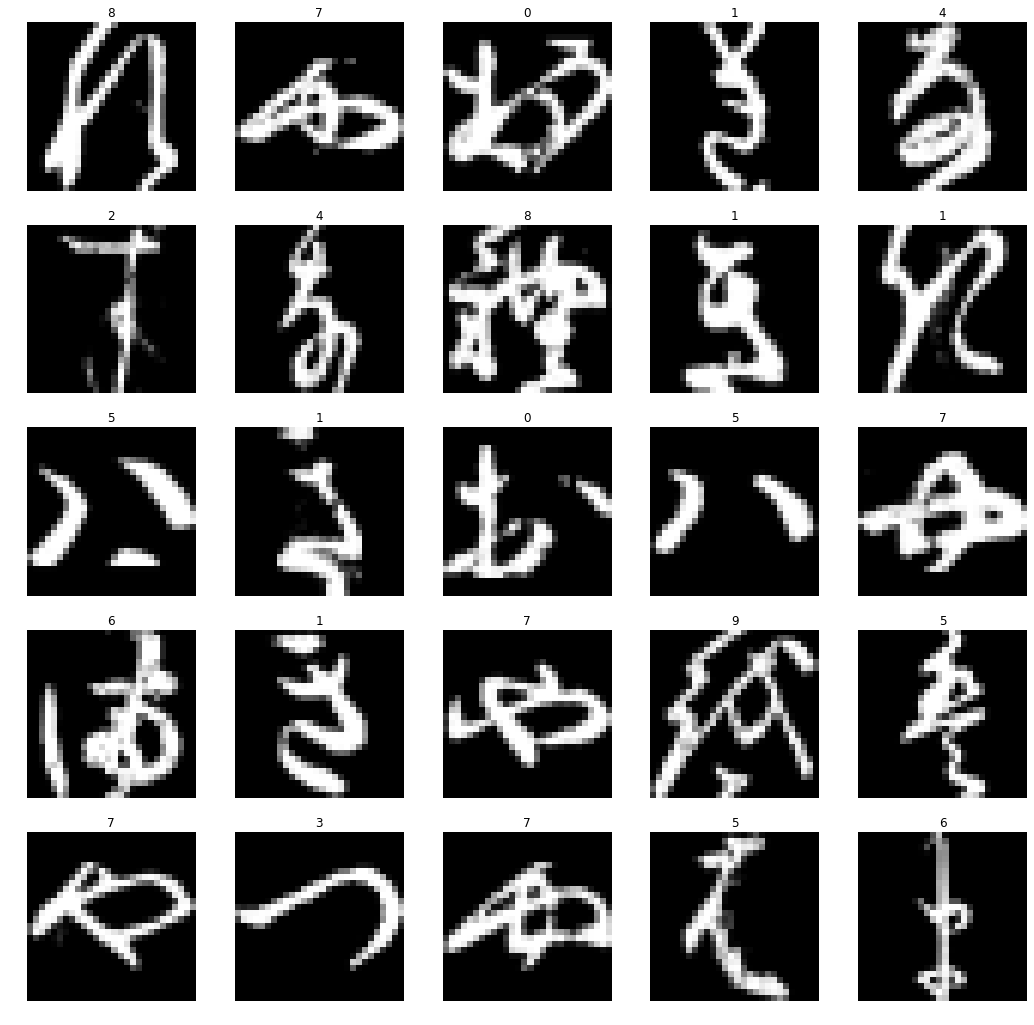

In [11]:
# setup the figure
fig, ax = plt.subplots(5, 5, figsize=[18,18])

# for each of the first 25 samples
for feat, targ, ax in zip(train_feat.data[:5*5],
                          train_targ[:5*5],
                          ax.flatten()):
    ax.imshow(feat[0, :, :], cmap="gray")
    ax.set(title=str(targ.item()))
    ax.axis("off")

## Data Splitting

Split the data with a StratifiedShuffleSplit into a 90% training 10% validation data set

In [12]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
shuffler = shuffler.split(train_feat, train_targ)

indices = list(shuffler)[0]
print(indices[0].shape, indices[1].shape)

(54000,) (6000,)


In [13]:
features_90 = train_feat[indices[0]]
targets_90 = train_targ[indices[0]]
features_10 = train_feat[indices[1]]
targets_10 = train_targ[indices[1]]

print(features_90.size(), targets_90.size(), features_10.size(), targets_10.size())

torch.Size([54000, 1, 28, 28]) torch.Size([54000]) torch.Size([6000, 1, 28, 28]) torch.Size([6000])


In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

In [0]:
# datasets
train_dataset    = TensorDataset(features_90, targets_90)
validate_dataset = TensorDataset(features_10, targets_10)
test_dataset = TensorDataset(test_feat)

# dataloaders
train_loader    = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=Test_Batch_Size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Test_Batch_Size, shuffle=False)

In [0]:
# # AlexNet_half
# class AlexNet_half(nn.Module):
#     """
    
#     """

#     def __init__(self, bias=True):
#         "setup the neural network"
        
#         # initalise
#         super(AlexNet_half, self).__init__()

#         # Original AlexNet
#         # self.C1_layer = nn.Conv2d(3, 48, padding=0, kernel_size=11, stride=4, bias=bias)
#         # self.P1_layer = nn.MaxPool2d(kernel_size=3, stride=2)
#         # self.C2_layer = nn.Conv2d(48, 128, padding=2, kernel_size=5, stride=1, bias=bias)
#         # self.P2_layer = nn.MaxPool2d(kernel_size=3, stride=2)
#         # self.C3_layer = nn.Conv2d(128, 192, padding=2, kernel_size=3, stride=1, bias=bias)
#         # self.C4_layer = nn.Conv2d(192, 128, padding=0, kernel_size=3, stride=1, bias=bias)
#         # self.F5_layer = nn.Linear(4068, 2048, bias=bias)
#         # self.F6_layer = nn.Linear(2048, 2048, bias=bias)
#         # self.output = nn.Linear(2048, 10, bias=bias)
        
#         # reduced AlexNet
#         self.C1_layer = nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias)
#         self.P1_layer = nn.MaxPool2d(kernel_size=1, stride=1)
#         self.C2_layer = nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias)
#         self.P2_layer = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.C3_layer = nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias)
#         self.C4_layer = nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias)
#         self.C5_layer = nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias)
#         self.P5_layer = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.F6_layer = nn.Linear(2304, 256, bias=bias)
#         self.F7_layer = nn.Linear(256, 256, bias=bias)
#         self.output = nn.Linear(256, 10, bias=bias)
        
#         # create the activation function
#         act = nn.ReLU()
        
#         # create a list of fucntion order
#         self.layers = [self.C1_layer, act, 
#                        self.P1_layer, act, 
#                        self.C2_layer, act, 
#                        self.P2_layer, act,
#                        self.C3_layer, act,
#                        self.C4_layer, act,
#                        self.C5_layer, act,
#                        self.P5_layer, act,
#                        self.flatten,
#                        self.F6_layer, act,
#                        self.F7_layer, act,
#                        self.output]
        
#     def flatten(self, T):
#         "flatten the image for the fully connected layers"
#         s = T.size(1)*T.size(2)*T.size(3)
#         print(s)
#         return T.view(-1, s)
        
        
#     def forward(self, x):
#         "Pass through the neural network"
#         for f in self.layers:
#             x = f(x)
#         return x


In [0]:
# AlexNet_half (sequential)
class AlexNet_half(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduce number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_half, self).__init__()

        # create the activation function
        act = nn.ReLU()

        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=1, stride=1), act,
            nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(2304, 256, bias=bias), act,
            nn.Linear(256, 256, bias=bias), act,
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x


## Training the AlexNet Model

In [40]:
x = torch.randn((1, 1, 28, 28))
test_model = AlexNet_half()
y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())
n_params = sum([t.detach().numpy().size for t in test_model.parameters()])
print("Number of model Parameters: ", n_params)

Output (pre-softmax):
 [[-0.05183106 -0.00023494  0.02902081  0.05070065  0.05232093 -0.02206332
  -0.01177426  0.00702074 -0.04078042  0.041491  ]]
Number of model Parameters:  989410


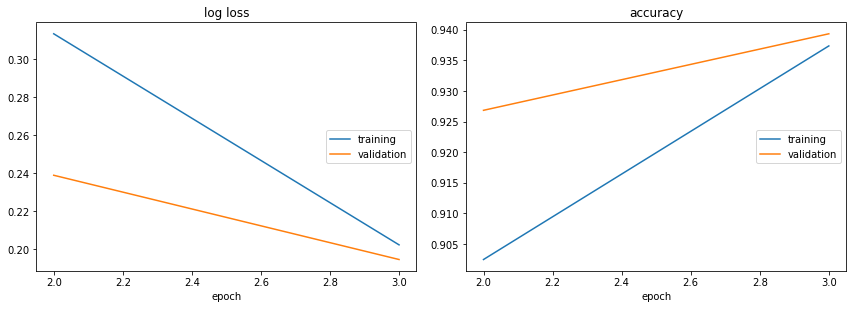

log loss:
training   (min:    0.202, max:    0.987, cur:    0.202)
validation (min:    0.195, max:    0.428, cur:    0.195)

accuracy:
training   (min:    0.682, max:    0.937, cur:    0.937)
validation (min:    0.865, max:    0.939, cur:    0.939)


KeyboardInterrupt: ignored

In [41]:
set_seed(Seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, validate_loader, criterion, device)
wrapper.train_model(Number_of_Epochs)

In [0]:
wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, test_loader, criterion, device)

In [0]:
output = wrapper.evaluate()
print(output)
# save_csv(output, "LeNet5_test")

[2 9 3 ... 9 4 2]
